In [1]:
import numpy as np
import torch
import os
from DS3Dplus.ds3d_utils import ImModelBase, ImModelTraining, Sampling, calc_jaccard_rmse, Volume2XYZ
import matplotlib.pyplot as plt
import matplotlib
from pathlib import Path
import pickle
from skimage import io
from torch.nn.functional import interpolate
import time
from datetime import datetime
import csv
from numpy import pi
from torch import nn
from numpy import savetxt


In [2]:
training_result_path = os.path.join(os.getcwd(), "training_results", "10-24_09-03")
exp_imgs_path = os.path.join(os.getcwd(), "dataset2", "laminB1_dense_dh_br")
blob_r = 2
threshold = 40
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

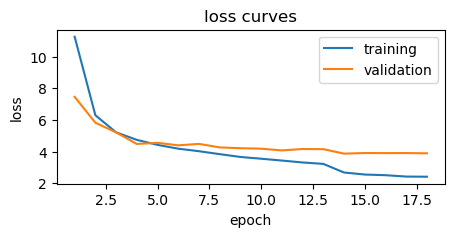

In [3]:
with open(os.path.join(training_result_path, 'fit.pickle'), 'rb') as handle:
    fit_result = pickle.load(handle)
num_epochs = fit_result.num_epochs
train_loss = fit_result.train_loss
test_loss = fit_result.test_loss

num_epochs = len(train_loss)
plt.figure(figsize=(5, 2))
plt.plot(np.arange(1, num_epochs+1), train_loss, label='training')
plt.plot(np.arange(1, num_epochs+1), test_loss, label='validation')
plt.legend()
plt.title('loss curves')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()


In [4]:
with open(os.path.join(training_result_path, 'param.pickle'), 'rb') as handle:
    param_dict = pickle.load(handle)
param_dict['device'] = device
param_dict['blob_r'] = blob_r
param_dict['threshold'] = threshold 

checkpoint = torch.load(os.path.join(training_result_path, "net.pt"), map_location=device)
net = checkpoint['net']
net.load_state_dict(checkpoint['state_dict'])


<All keys matched successfully>

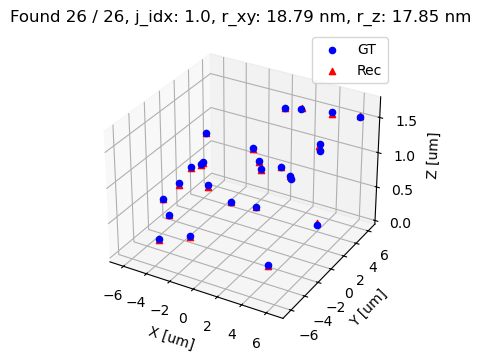

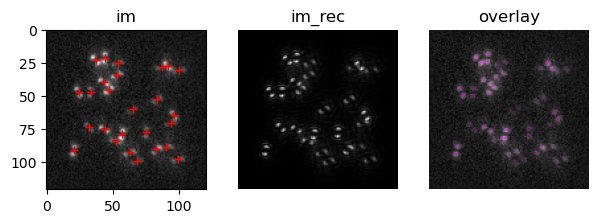

In [5]:
# simulation
dis_threshold = 0.1 # um
np.random.seed(11)
torch.manual_seed(11)

model = ImModelTraining(param_dict)
sampling = Sampling(param_dict)
volume2xyz = Volume2XYZ(param_dict)

xyzps, _, _ = sampling.xyzp_batch()
im = model(torch.from_numpy(xyzps).to(device)).cpu().numpy().astype(np.float32)
if param_dict['project_01']:
    im = ((im - im.min()) / (im.max() - im.min())).astype(np.float32)
    
with torch.no_grad():
    net.eval()
    vol = net(torch.from_numpy(im[np.newaxis, np.newaxis, :, :]).to(device))
xyz_rec, conf_rec = volume2xyz(vol)  # xy localizations relative to the FOV center


if xyz_rec is not None:
    xyz_gt = xyzps[:, :-1]
    jaccard_index, RMSE_xy, RMSE_z, _ = calc_jaccard_rmse(xyz_gt, xyz_rec, dis_threshold)   # set the radius
    jaccard_index, RMSE_xy, RMSE_z = np.round(jaccard_index, decimals=2), np.round(RMSE_xy*1000, decimals=2), np.round(RMSE_z*1000, decimals=2)
    
    # plot 1: emitters in 3d space
    fig = plt.figure(figsize=(5, 4))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(xyz_gt[:, 0], xyz_gt[:, 1], xyz_gt[:, 2], c='b', marker='o', label='GT', depthshade=False)
    ax.scatter(xyz_rec[:, 0], xyz_rec[:, 1], xyz_rec[:, 2], c='r', marker='^', label='Rec', depthshade=False)
    ax.set_xlabel('X [um]')
    ax.set_ylabel('Y [um]')
    ax.set_zlabel('Z [um]')
    if RMSE_xy is not None:
        plt.title(f'Found {xyz_rec.shape[0]} / {xyz_gt.shape[0]}, j_idx: {jaccard_index}, r_xy: {RMSE_xy} nm, r_z: {RMSE_z} nm')
    else:
        plt.title(f'Found {xyz_rec.shape[0]} emitters out of {xyz_gt.shape[0]}')
    plt.legend()
    
    
    nphotons_rec = (param_dict['Nsig_range'][0]+param_dict['Nsig_range'][1])/2 * np.ones(xyz_rec.shape[0])
    psfs_rec = model.get_psfs(torch.from_numpy(np.c_[xyz_rec, nphotons_rec]).to(device)).cpu().numpy()
    im_rec = np.sum(psfs_rec, axis=0)
    im_rec = (im_rec-im_rec.min())/(im_rec.max()-im_rec.min())
    im = (im-im.min())/(im.max()-im.min())
    
    ps_xy = param_dict['vs_xy']*param_dict['us_factor']
    h, w = im.shape
    ch, cw = (h-1)/2, (w-1)/2
    
    fig = plt.figure(figsize=(7, 3))
    plt.subplot(1, 3, 1)
    plt.imshow(im, cmap='gray')
    plt.plot(xyz_rec[:, 0] / ps_xy + cw, xyz_rec[:, 1] / ps_xy + ch, 'r+')
    plt.title('im')
    

    plt.subplot(1, 3, 2)
    plt.imshow(im_rec, cmap='gray')
    plt.title('im_rec')
    plt.axis('off')

    mask = np.max(psfs_rec, axis=0)
    mask = (mask-mask.min())/(mask.max()-mask.min())
    mask = 1-mask
    # transparency = 0.2+mask*0.8
    # im_overlay = np.stack((im, im, im, transparency), axis=-1)
    im_overlay = np.stack((im, im, im), axis=-1)
    im_overlay[:, :, 1] = im_overlay[:, :, 1] * mask
    plt.subplot(1, 3, 3)
    plt.imshow(im_overlay)
    plt.title('overlay')
    plt.axis('off')
    plt.show()
    
else:
    print('xyz_rec is empty.')
 



In [6]:
img_names = sorted(os.listdir(exp_imgs_path))
num_imgs = len(img_names)
print(f'the number of images: {num_imgs}')

the number of images: 95


found 152 particles


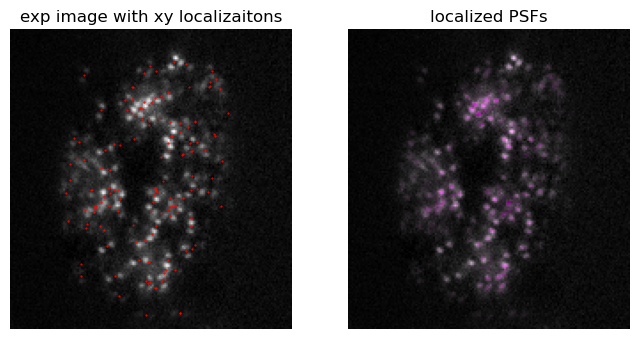

In [9]:
### specify post-processing parameters for experimental images
im_idx = 0  # test on the idx image

volume2xyz = Volume2XYZ(param_dict)
im_path = os.path.join(exp_imgs_path, img_names[im_idx])
im = io.imread(im_path).astype(np.float32)
if param_dict['project_01']:
    im = ((im - im.min()) / (im.max() - im.min())).astype(np.float32)
with torch.no_grad():
    net.eval()
    vol = net(torch.from_numpy(im[np.newaxis, np.newaxis, :, :]).to(device))
    xyz_rec, conf_rec = volume2xyz(vol)

H, W = im.shape
param_dict['H'], param_dict['W'] = H, W
model = ImModelTraining(param_dict)    
if H > param_dict['phase_mask'].shape[0] or W > param_dict['phase_mask'].shape[1]:
    sf = max(H // param_dict['phase_mask'].shape[0] + 1, W // param_dict['phase_mask'].shape[1] + 1)
    param_dict['ps_BFP'] /= sf
    phase_mask = param_dict['phase_mask']
    HW = np.floor(param_dict['f_4f'] * param_dict['lamda'] / (
                param_dict['ps_camera'] * param_dict['ps_BFP']))  # simulation size
    HW = int(HW + 1 - (HW % 2))  # make it odd

    phase_mask = interpolate(torch.tensor(phase_mask).unsqueeze(0).unsqueeze(1), size=(HW, HW))
    param_dict['phase_mask'] = phase_mask[0, 0].numpy()
    model = ImModelTraining(param_dict)
    
photons_rec = (param_dict['Nsig_range'][0]+param_dict['Nsig_range'][1])/2
nphotons_rec = photons_rec * np.ones(xyz_rec.shape[0])
psfs_rec = model.get_psfs(torch.from_numpy(np.c_[xyz_rec, nphotons_rec]).to(device)).cpu().numpy()
im_rec = np.sum(psfs_rec, axis=0)

print(f'found {xyz_rec.shape[0]} particles')
# plot
ps_xy = param_dict['vs_xy']*param_dict['us_factor']
h, w = im.shape
ch, cw = (h-1)/2, (w-1)/2

plt.figure(figsize=(8, 5))
plt.subplot(121)
imfig = plt.imshow(im, cmap='gray')
plt.plot(xyz_rec[:, 0] / ps_xy + cw, xyz_rec[:, 1] / ps_xy + ch, 'r.', markersize=1)
plt.title('exp image with xy localizaitons')
plt.axis('off')

plt.subplot(122)
im = (im-im.min())/(im.max()-im.min())
mask = (im_rec-im_rec.min())/(im_rec.max()-im_rec.min())
mask = 1-mask
im_overlay = np.stack((im, im, im), axis=-1)
im_overlay[:, :, 1] = im_overlay[:, :, 1] * mask
plt.imshow(im_overlay)
plt.title('localized PSFs')
plt.axis('off')

# plt.savefig('overlay.jpg', bbox_inches='tight', dpi=600)

plt.show()

In [12]:
# process all the images
# time of the entire dataset analysis
tall_start = time.time()
# needed pixel-size for plotting if only few images are in the folder
ps_xy = param_dict['ps_xy'] # FOV size, camera pixel size/magnification
# process all experimental images
net.eval()
results = np.array(['frame', 'x [nm]', 'y [nm]', 'z [nm]', 'intensity [au]'])
with torch.no_grad():
    for im_ind, im_name in enumerate(img_names):
        # time each frame
        tfrm_start = time.time()

        im = io.imread(os.path.join(exp_imgs_path, im_name)).astype(np.float32)
        if param_dict['project_01']:
            im = ((im - im.min()) / (im.max() - im.min())).astype(np.float32)
        vol = net(torch.from_numpy(im[np.newaxis, np.newaxis, :, :]).to(device))
        xyz_rec, conf_rec = volume2xyz(vol)

        # time it takes to analyze a single frame
        tfrm_end = time.time() - tfrm_start

        # if this is the first image, get the dimensions and the relevant center for plotting
        if im_ind == 0:
            H, W = im.shape
            ch, cw = H / 2, W / 2

        # if prediction is empty then set number fo found emitters to 0
        # otherwise generate the frame column and append results for saving
        if xyz_rec is None:
            nemitters = 0
        else:
            nemitters = xyz_rec.shape[0]
            frm_rec = (im_ind + 1) * np.ones(nemitters)
            
            xnm = (xyz_rec[:, 0] + cw * ps_xy) * 1000
            ynm = (xyz_rec[:, 1] + ch * ps_xy) * 1000
            znm = (xyz_rec[:, 2]) * 1000
            xyz_save = np.c_[xnm, ynm, znm]
            
            results = np.vstack((results, np.column_stack((frm_rec, xyz_save, conf_rec))))
            if im_ind % (num_imgs // 10) == 0:
                print('Processed Image [%d/%d]' % (im_ind + 1, num_imgs))
                # print status
                print('Single frame complete in {:.6f}s, found {:d} emitters'.format(tfrm_end, nemitters))

# print the time it took for the entire analysis
tall_end = time.time() - tall_start
print('=' * 50)
print('Analysis complete in {:.0f}h {:.0f}m {:.0f}s'.format(
    tall_end // 3600, np.floor((tall_end / 3600 - tall_end // 3600) * 60), tall_end % 60))
print('=' * 50)

time_now = datetime.today().strftime('%m-%d_%H-%M')

file_name = exp_imgs_path + "_loc_" + time_now + '.csv'
with open(file_name, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(results.tolist())
print(f'{file_name} is saved.')


Processed Image [1/95]
Single frame complete in 0.030768s, found 152 emitters
Processed Image [10/95]
Single frame complete in 0.009602s, found 167 emitters
Processed Image [19/95]
Single frame complete in 0.000000s, found 165 emitters
Processed Image [28/95]
Single frame complete in 0.015758s, found 157 emitters
Processed Image [37/95]
Single frame complete in 0.008134s, found 141 emitters
Processed Image [46/95]
Single frame complete in 0.007976s, found 149 emitters
Processed Image [55/95]
Single frame complete in 0.000000s, found 159 emitters
Processed Image [64/95]
Single frame complete in 0.008636s, found 149 emitters
Processed Image [73/95]
Single frame complete in 0.007977s, found 159 emitters
Processed Image [82/95]
Single frame complete in 0.018070s, found 166 emitters
Processed Image [91/95]
Single frame complete in 0.016050s, found 155 emitters
Analysis complete in 0h 0m 1s
C:\Users\dafei.xiao\Desktop\autods3d\dataset2\laminB1_dense_dh_br_loc_10-24_14-28.csv is saved.
